
# Fine-Tuning of the (Bio-)ELECTRA model on the PubMed RCT 20k dataset

Today you will use a modern NLP model, called ELECTRA (**E**fficiently **L**earning an **E**ncoder that **C**lassifies **T**oken **R**eplacements **A**ccurately), for sentence classification of the PubMed 20k RCT dataset.

---

**BEFORE YOU START:** Change the runtime to GPU (runtime -> change type -> GPU). If you do it at a later point in the notebook, you have to repeat everything.

---

## Preparations

Before you start the training of your model the environment has to be prepared. Therefore the *datasets* and *transformers* packages have to be installed via pip.



In [23]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [24]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load the data

Now that the environment is prepared the data has to be processed. Download the dataset and convert it to a pandas.DataFrame. Use the *from_pandas* function of the [*datasets*](https://huggingface.co/docs/datasets/index.html) package to initialize a dataset containing the train, and test data. Afterward, tokenize the input and assign the correct labels.

### Hints

*   You will not need spaCy or nltk today
*   Check out the [transformers documentation](https://huggingface.co/transformers/) for help
*   Use the ElectraTokenizer for tokenization

### Tasks

1. Convert the data to a pandas.DataFrame
2. Initialize a dataset ([datasets.Dataset.from_pandas](https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.from_pandas))
3. Tokenize the datasets (hint: use the model uri to intialize the tokenizer)
4. Generate a numeric representation of the sentence labels (e.g., Background = 0, Methods = 1, ...)
5. Specify the output for the dataset (only use 'input_ids', and 'labels'; *hint: look at dataset.set_format()*)



In [143]:
import pandas as pd
from tqdm import tqdm
from os.path import join

def convert_to_df(file_path: str) -> pd.DataFrame:
    """Convert  documents to DataFrame

    Args:

        file_path (str): Path to train/dev/test files
    """
    instances = []
    with open(file_path, "r") as f:
        for line in tqdm(f.readlines(), desc=f"Process {file_path}"):
            if line.startswith("###") or len(line.strip()) == 0:
                next
            else:
                label, text = line.split("\t")
                instances.append({
                    "sentence": text,
                    "label": label
                })
    return pd.DataFrame(instances)

In [144]:
data_dir = '/gdrive/MyDrive/data'

In [145]:
train = convert_to_df(join(data_dir, "train.txt"))
dev = convert_to_df(join(data_dir, "dev.txt"))
test = convert_to_df(join(data_dir, "test.txt"))

Process /gdrive/MyDrive/data/test.txt: 100%|██████████| 35135/35135 [00:00<00:00, 950036.88it/s]


In [146]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['label'] = le.fit_transform(train['label'])
dev['label'] = le.transform(dev['label'])
test['label'] = le.transform(test['label'])

In [147]:
list(le.classes_)

['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

In [149]:
import datasets
train_ds = datasets.Dataset.from_pandas(train)
dev_ds = datasets.Dataset.from_pandas(dev)
test_ds = datasets.Dataset.from_pandas(test)

In [150]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")

def tokenization(example):
    return tokenizer(example["sentence"])

train_ds = train_ds.map(tokenization, batched=True)
dev_ds = dev_ds.map(tokenization, batched=True)
test_ds = test_ds.map(tokenization, batched=True)

loading configuration file https://huggingface.co/google/electra-small-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73
Model config ElectraConfig {
  "_name_or_path": "google/electra-small-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_v

  0%|          | 0/181 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

  0%|          | 0/31 [00:00<?, ?ba/s]

In [151]:
train_ds.set_format(type="pt", columns=["input_ids", "label"])
dev_ds.set_format(type="pt", columns=["input_ids", "label"])
test_ds.set_format(type="pt", columns=["input_ids", "label"])

In [152]:
train_ds[0] 

{'input_ids': tensor([  101,  2000,  8556,  1996, 21150,  1997,  1030,  3134,  1997,  3679,
          2659,  1011, 13004,  8700,  3653,  2094,  8977, 12898,  2638,  1999,
          9229,  3255,  1010, 12969,  1010,  1998, 22575,  2659,  1011,  3694,
         21733,  1999,  1996,  2460,  2744,  1998,  3251,  1996,  3466,  2052,
          2022,  8760,  2012,  1030,  3134,  1999,  3080,  6001,  2007,  8777,
          2000,  5729,  6181,  9808,  2618, 10441, 15265, 14778,  2483,  1006,
          1051,  2050,  1007,  1012,   102]), 'label': tensor(3)}

## Load the model


You will use the ELECTRA-small model as a starting point for the fine-tuning task. The _transformers_ package provides a ElectraForSequenceClassification class which you can use. To do so, you have to specify the number of labels the model should predict.

### Tasks

1. Load the pre-trained ELECTRA model with the correct number of features to predict
  * use the BioELECTRA-small model as a starting point --> the model uri is 'molly-hayward/bioelectra-small-discriminator' (see the [model documentation](https://huggingface.co/molly-hayward/bioelectra-small-discriminator))
2. Print the model structure and verify that everything is as expected


In [153]:
!nvidia-smi

Wed Aug  3 13:29:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |   4008MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [154]:
from transformers import ElectraForSequenceClassification, ElectraConfig

config=ElectraConfig.from_pretrained("google/electra-small-discriminator")
config.num_labels=5
electra_small = ElectraForSequenceClassification.from_pretrained("google/electra-small-discriminator", config=config)

print(electra_small)

loading configuration file https://huggingface.co/google/electra-small-discriminator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ca13c16218c6780ec76753d3afa19fcb7cc759e3f63ee87e441562d374762b3d.3dd1921e571dfa18c0bdaa17b9b38f111097812281989b1cb22263738e66ef73
Model config ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache":

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

## Train the model

Train the model using the [Trainer class](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer) of the transformers package. First, specify the training arguments (check [the documentation](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments) for a complete overview of the options) and then start the training.

### Tasks

1.   Specify suitable [training arguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) -> check out what the authors of the [ELECTRA paper](https://openreview.net/pdf?id=r1xMH1BtvB) used
2.   Implement a function that computes evaluation metrics during training
  * What metric could be used?
  * Look at the *compute_metrics* argument of the *Trainer* class
  * The function should take an [EvalPrediction](https://huggingface.co/transformers/internal/trainer_utils.html#transformers.EvalPrediction) as input and return a Dict with the metric names and values 
3.   Start the training (**verify that it runs on GPU**)
  * Pass the specified training arguments to the trainer
  * Pass the implemented metric function and evaluate on the test set during training
4. Optional: Use an [early stopping callback](https://huggingface.co/transformers/main_classes/callback.html#transformers.EarlyStoppingCallback) instead of a fixed number of epochs (hint: you need the dev set for that)
4. Optional: You can save and download the pretrained model --> if your instance stops, you can load the model again without training
5. Optional: Use mlflow to log, for instance, metrics during training
  * Save the data to a local folder (e.g., mlruns/) and access it later on using [this script](https://colab.research.google.com/drive/1dwQOZBPjcIPydyFYjJ_EN2oC0Go1KmM-?usp=sharing)



In [155]:
# Define training arguments for training
from transformers import TrainingArguments

learning_rate = 3e-4
adam_epsilon = 1e-6
adam_beta1 = 0.9
adam_beta2 = 0.999
lr_scheduler_type = 'linear'
warmup_ratio = 0.1
weight_decay = 0
per_device_train_batch_size = 32
num_train_epochs = 3

targs = TrainingArguments(output_dir=data_dir, 
                          learning_rate=learning_rate, 
                          adam_epsilon=adam_epsilon, 
                          adam_beta1=adam_beta1, 
                          adam_beta2=adam_beta2, 
                          lr_scheduler_type=lr_scheduler_type,
                          warmup_ratio=warmup_ratio,
                          weight_decay=weight_decay,
                          per_device_train_batch_size=per_device_train_batch_size,
                          num_train_epochs=num_train_epochs,
                          evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [156]:
# Define compute_metric function for evaluation
import numpy as np
from transformers import EvalPrediction
from typing import Dict

def compute_metrics(prediction: EvalPrediction) -> Dict[str, float]:
  # TODO: implement evaluation function
  logits, labels = prediction
  pred = np.argmax(logits, axis=-1)
  acc = datasets.load_metric('accuracy').compute(predictions=pred, references=labels)['accuracy']
  f1 = datasets.load_metric('f1').compute(predictions=pred, references=labels, average='micro')['f1']
  recall = datasets.load_metric('recall').compute(predictions=pred, references=labels, average='micro')['recall']
  return {
      "accuracy": acc,
      "f1-score": f1,
      "recall": recall
      }

In [158]:
# Instantiate Trainer Class
from transformers import Trainer

trainer = Trainer(
    model = electra_small,
    args= targs,
    train_dataset = train_ds,
    eval_dataset = dev_ds,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics
)

In [159]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 180040
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 16881


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Recall
1,0.505900,0.465720,0.833311,0.833311,0.833311
2,0.440500,0.414788,0.848669,0.848669,0.848669
3,0.362500,0.394266,0.860817,0.860817,0.860817


Saving model checkpoint to /gdrive/MyDrive/data/checkpoint-500
Configuration saved in /gdrive/MyDrive/data/checkpoint-500/config.json
Model weights saved in /gdrive/MyDrive/data/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /gdrive/MyDrive/data/checkpoint-500/tokenizer_config.json
Special tokens file saved in /gdrive/MyDrive/data/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /gdrive/MyDrive/data/checkpoint-1000
Configuration saved in /gdrive/MyDrive/data/checkpoint-1000/config.json
Model weights saved in /gdrive/MyDrive/data/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /gdrive/MyDrive/data/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /gdrive/MyDrive/data/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to /gdrive/MyDrive/data/checkpoint-1500
Configuration saved in /gdrive/MyDrive/data/checkpoint-1500/config.json
Model weights saved in /gdrive/MyDrive/data/checkpoint-1500/pytorch_model.bin
tok

TrainOutput(global_step=16881, training_loss=0.4721238908168299, metrics={'train_runtime': 2179.9312, 'train_samples_per_second': 247.769, 'train_steps_per_second': 7.744, 'total_flos': 3021686331518400.0, 'train_loss': 0.4721238908168299, 'epoch': 3.0})

## Evaluate your model

### Tasks

1. Run predictions on the test dataset
2. Optional: Generate a plot with the train/eval loss over time (manually or with mlflow)
3. Calculate the average and class-wise F1 scores (look at sklearn.metrics.classification_report)

When you are finished with the tasks, repeat the training and evaluation for the ELECTRA-small model from Google (huggingface model uri = 'google/electra-small-discriminator') and compare its performance to the BioELECTRA-small model. If there is no time left, you do not have to do this task.

In [172]:
from sklearn.metrics import classification_report

predition = trainer.predict(test_dataset = test_ds)
y_pred = np.argmax(predition.predictions, axis = 1)
y_true = predition.label_ids

The following columns in the test set don't have a corresponding argument in `ElectraForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `ElectraForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 30135
  Batch size = 8


In [177]:
target_names = list(le.classes_)
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

  BACKGROUND       0.68      0.75      0.71      3621
 CONCLUSIONS       0.81      0.79      0.80      4571
     METHODS       0.91      0.94      0.92      9897
   OBJECTIVE       0.74      0.57      0.64      2333
     RESULTS       0.91      0.90      0.90      9713

    accuracy                           0.85     30135
   macro avg       0.81      0.79      0.80     30135
weighted avg       0.85      0.85      0.85     30135



## Visualizations

### Tasks

1. Visualize the calcultated metrics (e.g., with a barplot)
2. Optional: Generate a tSNE visualization of the ELECTRA representations and use the sentence label for coloring
  * You need the output of the base model --> Initialize the transformers.ElectraModel with the weights of your fine-tuned model
  * Pass the test data through the model and use the *last_hidden_state* that is returned by the model (see the [documentation](https://huggingface.co/transformers/model_doc/electra.html#transformers.ElectraModel.forward))
  * Use sklearn.manifold.TSNE to calculate 2 tSNE components
  * Visualize the representation in a scatterplot (e.g., look at seaborn.scatterplot) and use the sentence labels as color
3. Optional: Generate a PCA visualization for the ELECTRA representations and compare it to the tSNE plot

In [191]:
df = pd.DataFrame.from_dict(classification_report(y_true, y_pred, output_dict=True)).transpose()[:5]
df['label'] = list(le.classes_)
df
                            

,precision,recall,f1-score,support,label
0,0.676692,0.745650,0.709499,3621.0,BACKGROUND
1,0.809821,0.793699,0.801679,4571.0,CONCLUSIONS
2,0.909953,0.940386,0.924919,9897.0,METHODS
3,0.739855,0.570510,0.644240,2333.0,OBJECTIVE
4,0.908280,0.901266,0.904759,9713.0,RESULTS


Text(0.5, 1.0, 'Model Evaluation: ELECTRA-small')

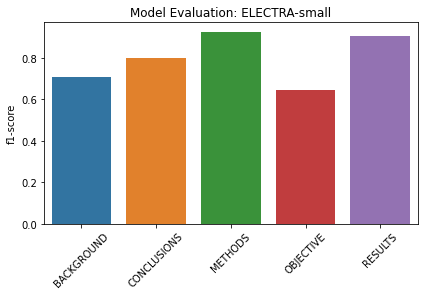

In [195]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='label', y='f1-score', data=df)

plt.xticks(rotation=45)
plt.xlabel('')
plt.tight_layout()
plt.title("Model Evaluation: ELECTRA-small")